In [16]:
import numpy as np
import xarray as xr
import matplotlib.pylab as plt

In [17]:
from core_fct.mod_process import OSCAR
from core_fct.fct_loadP import load_all_param
from core_fct.fct_genMC import generate_config
from run_scripts.get_SSP_drivers import For_hist
from run_scripts.get_SSP_drivers import For_scen

In [18]:
from matplotlib.gridspec import GridSpec

In [19]:
Par0 = load_all_param(mod_region='RCP_5reg')
Par = generate_config(Par0, nMC=200)
Par = xr.merge([Par, For_hist.drop([VAR for VAR in For_hist if 'year' in For_hist[VAR].dims])])
For_hist = For_hist.drop([VAR for VAR in For_hist if 'year' not in For_hist[VAR].dims])

Out_hist = OSCAR(Ini=None, Par=Par, For=For_hist)

loading primary parameters
generating MC configurations
OSCAR_v3 running
year = 2014 (nt = 3)
total running time: 4.8 minutes


In [20]:
For_scen = For_scen.sel(year=slice(None, 2100))
Ini = Out_hist.isel(year=-1, drop=True)
var_keep = ['D_Eluc', 'D_Focean', 'D_Fland', 'D_Epf'] + ['tau_CH4', 'tau_N2O'] + ['RF_CH4','RF_O3t']+['D_O3t']+['f_kOH_O3P']
Out_scen = OSCAR(Ini=Ini, Par=Par, For=For_scen, var_keep=var_keep, nt=4)
if False: Out_scen.to_netcdf('results/Out_scen_test.nc')

import matplotlib.pyplot as plt
def f_plot(VAR):
    plt.figure()
    if VAR in Out_hist:
        plt.plot(Out_hist.year, Out_hist[VAR].mean('config'), color='k', lw=2, label='hist')
        plt.fill_between(Out_hist.year, Out_hist[VAR].mean('config') - Out_hist[VAR].std('config'), 
            Out_hist[VAR].mean('config') + Out_hist[VAR].std('config'), color='k', alpha=0.5)
    for scen in Out_scen.scen.values:
        plt.plot(Out_scen.year, Out_scen[VAR].sel(scen=scen).mean('config'), lw=2, label=scen)
        plt.fill_between(Out_scen.year, Out_scen[VAR].sel(scen=scen).mean('config') - Out_scen[VAR].sel(scen=scen).std('config'), 
            Out_scen[VAR].sel(scen=scen).mean('config') + Out_scen[VAR].sel(scen=scen).std('config'), alpha=0.5)
    plt.title(VAR + ' (' + Out_scen[VAR].units + ')')


OSCAR_v3 running
year = 2100 (nt = 9)
total running time: 5.3 minutes


In [21]:
Ini = Out_hist.isel(year=-1, drop=True)
x2_OH_NOX = 0.00414
x2_OH_CO = -0.00024
x2_OH_VOC = -0.00027
Ini['D_CH4'] = 1822.61-Par0.CH4_0 # https://gml.noaa.gov/webdata/ccgg/trends/ch4/ch4_annmean_gl.txt

In [22]:
Par_tmp = Par.copy(deep=True)
For_scen_tmp = For_scen.sel(year=slice(None, 2050)).copy(deep=True).drop_vars('D_CH4')

In [23]:
Par_tmp.kOH_is_Log.values = np.array([False]*200)

Par_tmp.x2_OH_NOX.values = np.array([0.00414]*200)
Par_tmp.x2_OH_CO.values = np.array([-0.00024]*200)
Par_tmp.x2_OH_VOC.values = np.array(-0.00027)

In [24]:
Out_scen = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen.copy(deep=True).sel(year=slice(2014,2030)), var_keep=var_keep, nt=4)

OSCAR_v3 running
year = 2030 (nt = 4)
total running time: 0.7 minutes


# 甲烷控制效应
以Global methane pledge (GMP)

In [37]:
## 生成三个排放情景

## 2014-2019 (CEDS)
CEDS_CH4 = [270.2496358,269.8280079,267.9817751,268.1138598,270.537411,271.6083044]
CEDS_NOX = [38.59678516,37.98745474,37.48333497,37.43483474,37.16926467,36.81225668]
CEDS_CO = [247.089963,241.5313653,233.9000087,230.9691292,228.7215534,226.6449276]
CEDS_VOC = [149.9870685,148.9745692,148.276486,148.5098291,147.521796,146.6675455]

For_scen_real = For_scen_tmp.copy(deep=True).sel(scen=['SSP5-8.5','SSP5-8.5','SSP5-8.5']).assign_coords(scen=np.array(['middle','clean','polluted']))
For_scen_real.E_CH4[0,6:] -= (For_scen_real.E_CH4.sel(year=2019).sum('reg_land').values-CEDS_CH4[-1])
for i in range(len(CEDS_CH4)):
    For_scen_real.E_CH4[:,i] *=0
    For_scen_real.E_CH4[0,i] +=CEDS_CH4[i]
for var in ['E_NOX','E_CO','E_VOC',]:
    For_scen_real[var][...,0] = For_scen_tmp[var].copy(deep=True).sel(scen='SSP2-4.5')
    For_scen_real[var][...,1] = For_scen_tmp[var].copy(deep=True).sel(scen='SSP1-1.9')
    For_scen_real[var][...,2] = For_scen_tmp[var].copy(deep=True).sel(scen='SSP3-7.0')
For_scen_real.E_NOX[0,6:] -= (For_scen_real.E_NOX.sel(year=2019).sum('reg_land').values-CEDS_NOX[-1])
For_scen_real.E_CO[0,6:] -= (For_scen_real.E_CO.sel(year=2019).sum('reg_land').values-CEDS_CO[-1])
For_scen_real.E_VOC[0,6:] -= (For_scen_real.E_VOC.sel(year=2019).sum('reg_land').values-CEDS_VOC[-1])

for i in range(len(CEDS_CH4)):
    For_scen_real.E_NOX[:,i] *=0
    For_scen_real.E_NOX[0,i] +=CEDS_NOX[i]
    For_scen_real.E_CO[:,i] *=0
    For_scen_real.E_CO[0,i] +=CEDS_CO[i]
    For_scen_real.E_VOC[:,i] *=0
    For_scen_real.E_VOC[0,i] +=CEDS_VOC[i]

In [38]:
Par_tmp['t_OH_CH4'] *= 0
Par_tmp['t_OH_CH4'] += 11.2

In [39]:
Out_scen_real = OSCAR(Ini=Ini, Par=Par_tmp, For=For_scen_real, var_keep=var_keep+['f_kOH','f_kOH_O3P', 'D_Ebb'], nt=4)

OSCAR_v3 running
year = 2050 (nt = 4)
total running time: 1.6 minutes


In [40]:
color_list = ['k','#41B365','#741A88',]

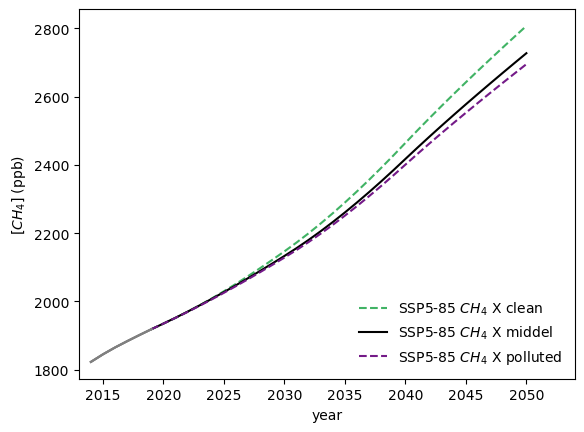

In [46]:
fig, ax = plt.subplots()

# ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),Out_scen_real.isel(scen=0).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,label='non-mitigation',
#          linestyle='-',color='r')
label_list = ['SSP5-85 $CH_4$ X middel','SSP5-85 $CH_4$ X clean','SSP5-85 $CH_4$ X polluted']
for i in [1,0,2]:
    if i == 0:
        linestyle = '-'
    else:
        linestyle = '--'
    ax.plot(Out_scen_real.year.sel(year=slice(2019,2050)),Out_scen_real.isel(scen=i).D_CH4.mean('config').sel(year=slice(2019,2050))+Par0.CH4_0,label=label_list[i],
             linestyle=linestyle,color=color_list[i])
ax.plot(Out_scen_real.year.sel(year=slice(2014,2019)),Out_scen_real.D_CH4.sel(year=slice(2014,2019)).mean('config')+Par0.CH4_0,color='grey')


def plot_quiver(ax,point1,point2,color='k',linestyle='-',headwidth=3.5):
    x0,y0 = point1
    x1,y1 = point2
    ax.plot([x0,x1],[y0,y1],color=color,linestyle=linestyle)
    ax.quiver(x1,y1,(x1-x0),(y1-y0),color=color, width=.01,headwidth=headwidth,)




ax.set_ylabel('$[CH_4]$ (ppb)')
ax.set_xlabel('year')
ax.legend(loc='lower right',frameon=False)
ax.set_xlim(2013,2054)
fig.savefig('测试甲烷ssp585.pdf',dpi=300)